# Bayesian amplitude regression

In the lectures you should've now covered, or at least discussed Bayesian networks.
Here we'll put this into practice by building a Bayesian neural network in pytorch to perform a regression task on the LHC amplitude for the production of two photons and a gluon in a gluon-gluon collision.

We want to train a network to predict the amplitude for the process $gg\rightarrow\gamma\gamma g$.  So the amplitude depends on the 4-momentum of 5 particles: 2 incoming gluons, 2 outgoing photons, and one outgoing gluon.  

The incoming gluons will have no transverse momentum, but their total momentum along the beam pipe is not necessarily zero.

The network we will train is a simple fully connected dense network.  This means that the input and output can only be vectors of real numbers.  We want to input the kinematic information on the particles to the network, and train the network to output the corresponding amplitude.

We will start by constructing a Bayesian layer in pytorch, and then building the Bayesian loss function.  We will then construct a Bayesian network from these layers, and use it to perform the same amplitude regression from the previous tutorial.  We will discuss how to analyse the outputs of the Bayesian network, and how this gives us the ability to estimate the error on our analysis.  This last step is crucial to the application of any numerical technique in physics.

#### Outline / tasks:
 - Imports \& plotting set-up
 - Loading the data
 - Visualising the data
     - visualise some of the kinematics of the process (transverse momentum of photons/gluons, MET)
     - histogram the amplitudes
 - Preprocessing the data
     - neural networks like $\mathcal{O}(1)$ numbers
     - how should we preprocess the data?
 - Datasets and dataloaders
     - details are in the pytorch docs
 - Building a Bayesian layer
 - Constructing the Bayesian loss function
 - Building the Bayesian neural network
 - Optimising the neural network
 - Plot the train and validation losses as a function of the epochs
 - Study the results

     
Most practical pytorch skills you need for this work is covered in the basics tutorial at https://pytorch.org/tutorials/beginner/basics/intro.html.

Please download the training data `tutorial-2-data.zip` and extract it to the folder `data/tutorial-2-data/`.

Check out the full series of notebook at: https://github.com/heidelberg-hepml/ml-tutorials

If you want to run this tutorial in google colab, you can open a new colab and then upload this file.

The data can be downloaded using

In [1]:
# !wget -O tutorial-2-data.zip https://www.dropbox.com/s/n5e66w91rgmbqz2/dlpp-data.zip?dl=0&file_subpath=%2Fdlpp-data%2Ftutorial-2-data
# !unzip "tutorial-2-data.zip"
# !mkdir tutorial-2-data
# !mv dlpp-data/tutorial-2-data/* tutorial-2-data/.
# !rm -r __MACOSX/
# !rm -r dlpp-data/
# !ls

Make sure you switch to a GPU runtime to fully utilize the colab.

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys


## Loading the data

In [3]:
trn_dat = np.load("tutorial-2-data/trn_dat.npy")
trn_amp = np.load("tutorial-2-data/trn_amp.npy")

val_dat = np.load("tutorial-2-data/val_dat.npy")
val_amp = np.load("tutorial-2-data/val_amp.npy")

tst_dat = np.load("tutorial-2-data/tst_dat.npy")
tst_amp = np.load("tutorial-2-data/tst_amp.npy")

In [4]:
print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


## Visualising the data

Below we will make some kinematic plots of the events in the training sample.  Note however that these are not the physical distributions we would measure at the LHC!  In our training data each of these events is associated with an amplitude, which tells us the probability that the event will be produced in the gluon-gluon interaction.  So to get the physical distributions these events would need to be 'weighted' by their amplitude.  However, right now we just want to visualise our training dataset to see what preprocessing we should do.

In [5]:
def get_init_pz( ev ):
    return ev[0][3] + ev[1][3]

def get_mass( fv ):
    msq = np.round( fv[0]**2 - fv[1]**2 - fv[2]**2 - fv[3]**2 , 5 )
    if msq>0:
        return np.sqrt( msq )
    elif msq<0:
        raise Exception( "mass squared is less than zero" )
    else:
        return 0

def get_pt( fv ):
    ptsq = np.round( fv[1]**2 + fv[2]**2 , 5 )
    if ptsq>0:
        return np.sqrt( ptsq )
    elif ptsq<0:
        raise Exception( "$p_T$ squared is less than zero" )
    else:
        return 0

def get_met( ev ):
    return np.abs( np.sum( [ fv[1]+fv[2] for fv in ev ] ) )

Plotting the initial $p_z$ of the events in the training sample.

In [6]:
trn_dat_init_pz = []
for ev in trn_dat:
    trn_dat_init_pz.append( get_init_pz( ev ) )

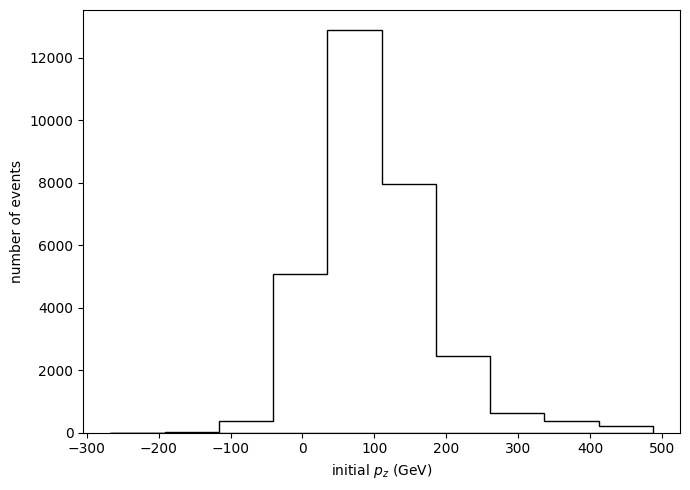

In [7]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_dat_init_pz, histtype='stepfilled', fill=None )

axs.set_xlabel( "initial $p_z$ (GeV)")
axs.set_ylabel( "number of events")

fig.tight_layout()

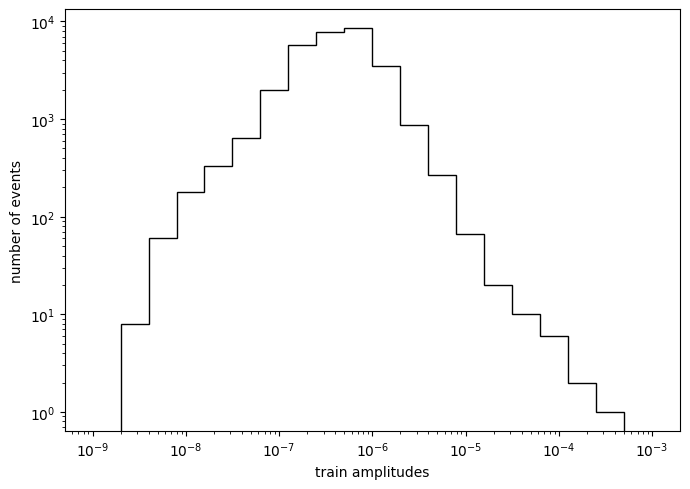

In [8]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

bins=np.logspace(-9, -3, 21)
axs.hist( trn_amp, histtype='stepfilled', fill=None, bins=bins )

axs.set_yscale( 'log' )
axs.set_xscale( 'log' )

axs.set_xlabel( "train amplitudes" )
axs.set_ylabel( "number of events" )

fig.tight_layout()

Plotting the leading photon $p_T$.

In [9]:
trn_dat_leading_photon_pt = []
for ev in trn_dat:
    trn_dat_leading_photon_pt.append( get_pt( ev[2] ) )

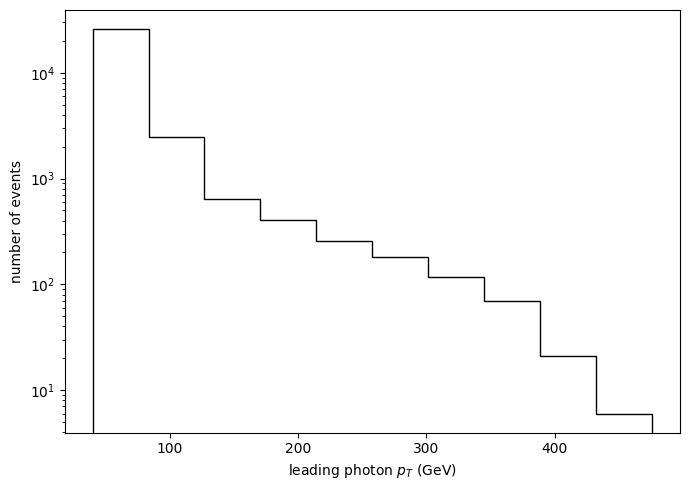

In [10]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_dat_leading_photon_pt, histtype='stepfilled', fill=None )

axs.set_yscale( 'log' )

axs.set_xlabel( "leading photon $p_T$ (GeV)")
axs.set_ylabel( "number of events" )

fig.tight_layout()

## Preprocessing the data

We will be using a dense network, so the data needs to be in vector format.  We will collapse the data for each event to a single vector of dimension $5\times4=20$.  The fact that the data is ordered here is important.  To predict the amplitude given the kinematics, the network needs to know which entries correspond to which particles in the process.

In [11]:
def get_pt(fv):
    """ returns p_T of given four vector """
    ptsq = np.round(fv[:, 1]**2 + fv[:, 2]**2, 5)
    return np.sqrt(ptsq)

In [12]:
# index 2 is leading photon, not gluon (which is 4)
trn_dat_gluon_pt = get_pt(trn_dat[:, 4])



In [13]:
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev,-1))
val_datf = np.reshape(val_dat, (nev,-1))
tst_datf = np.reshape(tst_dat, (nev,-1))

In [14]:
trn_datf.shape

(30000, 20)

There are further preprocessing steps we can take.  For example, the inputs are numerically very large $\mathcal{O}(100)$ and span a large range.  So we could re-scale the inputs by a constant number, or even take the logarithm of the inputs.

For now, we'll just re-scale by a constant number, the average final state gluon $p_T$, assuming that this is a natural scale for the problem.  And we should be careful to preprocess the train, validation, and test data in the exact same way.

In [15]:
gpt = np.mean(trn_dat_gluon_pt)
trn_datf = trn_datf / gpt
val_datf = val_datf / gpt
tst_datf = tst_datf / gpt

In [16]:
trn_datfp = torch.Tensor(trn_datf)
val_datfp = torch.Tensor(val_datf)
tst_datfp = torch.Tensor(tst_datf)

We should also preprocess the amplitude data.  As we have seen in the plot above, the amplitudes span about 4 orders of magnitude.  This could be difficult for the network to interpolate.  We can aleviate the problem with preprocessing, taking the logarithm of the amplitudes.

In [17]:
trn_ampl = np.log(trn_amp)
val_ampl = np.log(val_amp)
tst_ampl = np.log(tst_amp)

In [18]:
trn_amplp = torch.Tensor(trn_ampl)
val_amplp = torch.Tensor(val_ampl)
tst_amplp = torch.Tensor(tst_ampl)

## Datasets and dataloaders

In [19]:
class amp_dataset(Dataset):

    def __init__(self, data, amp):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

In [20]:
trn_dataset = amp_dataset(trn_datfp, trn_amplp.unsqueeze(-1))
val_dataset = amp_dataset(val_datfp, val_amplp.unsqueeze(-1))
tst_dataset = amp_dataset(tst_datfp, tst_amplp.unsqueeze(-1))

In [21]:
trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=64, shuffle=True)

## Building a Bayesian layer

First let's look at the source code for a **basic linear layer** in pytorch:

(https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)

```
class Linear(Module):
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
```

Objects of this class apply a linear transformation to the incoming data: $y = xA^T + b$.

The input arguments are required to initialise the layer, so, in the \_\_init()\_\_ function.  We have:
- in_features: size of each input sample
- out_features: size of each output sample
- bias: If set to ``False``, the layer will not learn an additive bias.  Default: ``True``

The shapes are:
- Input: $(*, H_{in})$ where $*$ means any number of dimensions including none and $H_{in} = \text{in\_features}$.
- Output: $(*, H_{out})$ where all but the last dimension are the same shape as the input and $H_{out} = \text{out\_features}$.

The layer has attributes:
- weight: the learnable weights of the module of shape $(\text{out_features}, \text{in\_features})$. The values are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{\text{in\_features}}$
- bias:   the learnable bias of the module of shape $(\text{out_features})$.  If `bias` is ``True``, the values are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$ where $k = \frac{1}{\text{in\_features}}$.

Examples::

    >>> m = nn.Linear(20, 30)
    
    >>> input = torch.randn(128, 20)
    
    >>> output = m(input)
    
    >>> print(output.size())
    
    torch.Size([128, 30])

From the lecture, we know that in a Bayesian network the weights are replaced by Gaussian distributions, and on a forward pass we get the output by sampling from that distribution.

So the biases are the same as in the linear layer.  But not each weight is a Gaussian distibution and so needs a mean and a variance.  The bias and the mean and variance of the weight distribution will be learnable.  In practice it's easier to work with the log of the variance as it is more stable when optimising the network.

We need to be able to sample from the Gaussian weight distributions, and compute derivatives of the output in order to update the network parameters. To do this we use something called the 're-parameterisation trick'. It involves sampling random noise from a unit normal distribution, and then transforming that number using the mean and variance of the weight distribution in this way:
\begin{equation}
w = \mu + \sigma\times r
\end{equation}

where $r$ is a random number sampled from a unit normal distribution (Gaussian with mean and variance equal to one), $\mu$ is the mean of the weight distribution, and $\sigma$ is the standard deviation. In this way we separate the stochastic part of the function from the parameters defining the distribution. And so if we take any differentiable function of $x$ (e.g. an activation function), we can compute derivatives of that function with respect to the mean and variance of the weight distribution.

In the `forward` method we then need to implement this reparameterisation trick for the weights, and then apply the same linear transformation as in the standard linear layer.

On each forward pass we need to generate a set of random numbers with the same shape as our means and variances.  Choosing a set of random numbers for the sampling is equivalent to 'sampling' a new neural network from the Bayesian neural network.  And sometimes at the end of the analysis, we will want to keep the same network for testing.  So we don't always want to re-sample the random numbers on each forward pass.  To control this we define a flag called `self.resample`, with default set to ``True``.

We also need a `reset_parameters` function to reset the parameters in the network.  This is standard for layers in pytorch.  We use a slightly different function to do this than is used in the pytorch linear layer, as can be seen below.

From the lecture, you know that the weight distributions require a prior.  The simplest choice for this prior is just a Gaussian distribution with mean zero and variance of one.  Results are typically not too sensitive to this prior, as long as the values are within reasonable limits.  For example, $\mathcal{O}(1)$ means and standard deviations.  Going beyond $\mathcal{O}(1)$ numbers just leads to numerical instabilities in the training.  The Bayesian loss function contains a term coming from the KL divergence between the weight distributions in the network and their priors.  So the layers should have some funcitonality to return these values.  The KL divergence for the layer is:
\begin{equation}
\text{KL} = \sum_{\text{weights}} 0.5 \times (  \mu^2 + \sigma^2 - \log\sigma^2 - 1 )
\end{equation}

So let's build the **simplest Bayesian layer** we can.

In [22]:
class VBLinear(Module):
    # VB -> Variational Bayes

    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features, out_features):
        super(VBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = True
        self.bias = Parameter(Tensor(out_features))
        self.mu_w = Parameter(Tensor(out_features, in_features))
        self.logsig2_w = Parameter(Tensor(out_features, in_features))
        self.random = torch.randn_like(self.logsig2_w)
        self.reset_parameters()

    def forward(self, inpt):
        if self.resample:
            self.random = torch.randn_like(self.logsig2_w)
        s2_w = self.logsig2_w.exp()
        weight = self.mu_w + s2_w.sqrt() * self.random
        return nn.functional.linear(inpt, weight, self.bias) #+ 1e-8

    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(-9, 0.001)
        self.bias.data.zero_()

    def KL(self, loguniform=False):
        kl = 0.5 * (self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w - 1).sum()
        return kl

Let's test the layers, define:

In [23]:
tlr0 = VBLinear(10, 5)
tlr1 = VBLinear(5, 2)

Now some test data, a batch of 20 vectors with 10 elements each:

In [24]:
x = torch.rand(20, 10)

Now pass the data first through layer0 then through layer1:

In [25]:
tlr1(tlr0(x))

tensor([[ 1.2939e-01,  5.1089e-02],
        [ 9.2927e-02,  2.8592e-02],
        [ 7.1920e-02, -1.1625e-01],
        [-3.3693e-01,  4.4730e-01],
        [-2.7412e-01,  1.8473e-01],
        [-9.8333e-02,  1.9014e-01],
        [-3.6462e-01, -6.8372e-02],
        [-1.4536e-01,  5.2579e-04],
        [ 4.0259e-01, -1.8532e-01],
        [-1.1095e-02,  1.2791e-02],
        [-1.3191e-01,  2.0943e-01],
        [-4.2843e-01,  2.5497e-01],
        [-1.4074e-01,  2.4615e-01],
        [-6.5990e-01,  3.7294e-01],
        [-6.5538e-01,  5.2654e-01],
        [-7.2243e-01,  7.7229e-01],
        [ 5.5343e-01,  6.2787e-02],
        [-1.2077e-01,  2.5722e-01],
        [-9.2315e-01,  4.7365e-01],
        [-1.1437e+00,  9.9178e-01]], grad_fn=<AddmmBackward0>)

Note this has the correct shape:

In [26]:
tlr1(tlr0(x)).shape

torch.Size([20, 2])

Also try running the same data through the layer multiple times, you get different results.  This is because of the sampling in the Bayesian layer.

In [27]:
for i in range(5):
    print(tlr0(x)[0][0])

tensor(0.6504, grad_fn=<SelectBackward0>)
tensor(0.6742, grad_fn=<SelectBackward0>)
tensor(0.6543, grad_fn=<SelectBackward0>)
tensor(0.6528, grad_fn=<SelectBackward0>)
tensor(0.6743, grad_fn=<SelectBackward0>)


## The Bayesian loss function

From the lectures we know that there are two parts to the Bayesian loss function:
- The negative log Gaussian
- the KL from the network weights

The second comes from the layers, and the first is defined below.  This negative log Gaussian term acts on the two outputs from the Bayesian neural network:
- the mean
- the variance (which we parameterise as the log variance)

In [28]:
def neg_log_gauss(outputs, targets):

    mu = outputs[:, 0]
    logsigma2 = outputs[:, 1]
    out = torch.pow(mu - targets, 2) / (2 * logsigma2.exp()) + 1./2. * logsigma2

    return torch.mean(out)

## Building the Bayesian neural network

We'll build a simple network with one input and one output layer, and two hidden layers.  We define the dimensions of these layers below.

In [29]:
ipt_dim = 20
opt_dim = 1
hdn_dim = 50

Now we build a very simple class for our neural network, which we call amp_net.

In [30]:
class bayes_amp_net(Module):

    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__(self, training_size, hdn_dim=50):

        super(bayes_amp_net, self).__init__()

        # the loss function depends on the amount of training data we have, so we need to store this
        self.training_size = training_size

        # the activation layers of the network are not bayesian
        # and we need to be able to access the bayesian layers separately

        self.vb_layers = []
        self.all_layers = []

        # define the input layer
        vb_layer = VBLinear(ipt_dim, hdn_dim)
        self.vb_layers.append(vb_layer)
        self.all_layers.append(vb_layer)
        self.all_layers.append(nn.ReLU())

        # loop over hidden layers
        for i in range(2):
            vb_layer = VBLinear(hdn_dim, hdn_dim)
            self.vb_layers.append(vb_layer)
            self.all_layers.append(vb_layer)
            self.all_layers.append(nn.ReLU())

        # define the output layer. use 2 dimensions to learn the uncertainty sigma_stoch=sigma_model,
        # see eq. 1.57 of 2211.01421
        vb_layer = VBLinear(hdn_dim, 2)
        self.vb_layers.append(vb_layer)
        self.all_layers.append(vb_layer)

        # define the model as a Sequential net over all layers
        self.model = nn.Sequential(*self.all_layers)

    # and of course the forward function
    def forward(self, x):
        out = self.model(x)
        return out

    # we need the KL from the bayesian layers to compute the loss function
    def KL(self):
        kl = 0
        for vb_layer in self.vb_layers:
            kl += vb_layer.KL()
        return kl / self.training_size

    # let's put the neg_log_gauss in the network class aswell since it is key to bayesian networks
    def neg_log_gauss(self, outputs, targets):
        mu = outputs[:, 0]
        logsigma2 = outputs[:, 1]
        out = torch.pow(mu - targets, 2) / (2 * logsigma2.exp()) + 1./2. * logsigma2
        return torch.mean(out)

Check if we have a GPU.

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Initialise the neural network and send to the GPU if we have one.  We can also print the model to see what layers it has.

In [32]:
trn_len = trn_amplp.shape[0]
hdn_dim = 50
model = bayes_amp_net(trn_len, hdn_dim=hdn_dim).to(device)
print(model)

bayes_amp_net(
  (model): Sequential(
    (0): VBLinear()
    (1): ReLU()
    (2): VBLinear()
    (3): ReLU()
    (4): VBLinear()
    (5): ReLU()
    (6): VBLinear()
  )
)


Now we can test it briefly by throwing some random numbers into it.

In [33]:
X = torch.rand(5, 20, device=device)

Passing the numbers through the Bayesian network gives us different outputs each time we run it:

In [34]:
model(X)

tensor([[ 0.0458, -0.0689],
        [ 0.0093, -0.1654],
        [ 0.0126,  0.1344],
        [ 0.0232,  0.0220],
        [-0.0800,  0.0032]], device='cuda:0', grad_fn=<AddmmBackward0>)

Note again that the output has the correct shape:

In [35]:
model(X).shape

torch.Size([5, 2])

The predicitons of the full Bayesian network should vary with each forward pass because of the weight sampling

In [36]:
# print predictions for the same input data
for i in range(5):
    print(model(X)[0])

tensor([-0.0367,  0.0062], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.0723, -0.0549], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.0479, -0.0850], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.0872, -0.0303], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0617, -0.1186], device='cuda:0', grad_fn=<SelectBackward0>)


## Optimising (training) the neural network

The Bayesian loss function has two terms which we have already definedl; the negative los Gaussian, and the KL divergence between the network and the network prior.  The latter comes from the KL divergence over the weights in the network.

Now we can write a training loop for a single epoch.

In [37]:
def train_epoch(dataloader, model, optimizer):

    size = len(dataloader.dataset)
    model.train()
    loss_tot, kl_tot, neg_log_tot = 0.0, 0.0, 0.0
    loss_during_opt, kl_during_opt, neg_log_during_opt = 0., 0., 0.

    for batch, (X, y) in enumerate(dataloader):

        # pass data through network
        pred = model(X)

        # compute loss
        nl = model.neg_log_gauss(pred, y.reshape(-1))
        kl = model.KL()
        loss = nl + kl

        loss_during_opt += loss.item()
        kl_during_opt += kl.item()
        neg_log_during_opt += nl.item()

        # reset gradients in optimizer
        optimizer.zero_grad()

        # compute gradients
        loss.backward()

        # update weights with optimizer
        optimizer.step()

        # print the training loss every 100 updates
        if batch % 100 == 0:
            current = batch * len( X )
            print(f"current batch loss: {loss:>8f} KL: {kl:>8f} Neg-log {nl:>8f}  [{current:>5d}/{size:>5d}]")
    loss_live = loss_during_opt/len(dataloader)
    kl_live = kl_during_opt / len(dataloader)
    nl_live = neg_log_during_opt / len(dataloader)

    print(f"avg train loss per batch in training: {loss_live:>8f}")
    return loss_live, kl_live, nl_live

To monitor the performance of the network on the regression task we want to calculate the loss of both the training data and the validation data on the same network, so we have the following functions:

In [38]:
def val_pass(dataloader, model):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    nls = 0.0
    kls = 0.0
    vls = 0.0
    mse = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            nl = model.neg_log_gauss(pred, y.reshape(-1))
            kl = model.KL()
            vl = nl.item() + kl.item()
            mse += torch.mean((pred[:, 0] - y.reshape(-1))**2)
            nls += nl
            kls += kl
            vls += vl

    nls /= num_batches
    kls /= num_batches
    vls /= num_batches
    mse /= num_batches
    print( f"avg val loss per batch: {vls:>8f} KL: {kls:>8f} Neg-log {nls:>8f} MSE {mse:>8}" )

    return nls.cpu().numpy(), kls.cpu().numpy(), vls, mse.cpu().numpy()

def trn_pass(dataloader, model):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    nls = 0.0
    kls = 0.0
    tls = 0.0
    mse = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            nl = model.neg_log_gauss(pred, y.reshape(-1))
            kl = model.KL()
            tl = nl.item() + kl.item()
            mse += torch.mean((pred[:, 0] - y.reshape(-1))**2)
            nls += nl
            kls += kl
            tls += tl

    nls /= num_batches
    kls /= num_batches
    tls /= num_batches
    mse /= num_batches
    print( f"avg trn loss per batch: {tls:>8f} KL: {kls:>8f} Neg-log {nls:>8f} MSE {mse:>8}" )

    return nls.cpu().numpy(), kls.cpu().numpy(), tls, mse.cpu().numpy()

Now we can train the model!

In [39]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# reset some parameters
batch_size = 128

trn_dataset = amp_dataset(trn_datfp.to(device), trn_amplp.unsqueeze(-1).to(device))
val_dataset = amp_dataset(val_datfp.to(device), val_amplp.unsqueeze(-1).to(device))
tst_dataset = amp_dataset(tst_datfp.to(device), tst_amplp.unsqueeze(-1).to(device))

trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=True)
epochs = 500

# re-initialise the model and the optimizer
hdn_dim = 50
trn_len = trn_amplp.shape[0]
print(f"Training dataset length: {trn_len}")
model = bayes_amp_net(trn_len, hdn_dim=hdn_dim).to(device)
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
seperator()
print("model architecture")
seperator()
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")


# track train and val losses
trn_nl_losses = []
trn_kl_losses = []
trn_losses = []
trn_mse_losses = []
val_nl_losses = []
val_kl_losses = []
val_losses = []
val_mse_losses = []
trn_nl_losses_live = []
trn_kl_losses_live = []
trn_losses_live = []

for t in range(epochs):
    seperator()
    print(f"Epoch {t+1}")
    seperator()
    loss_live, kl_live, nl_live = train_epoch(trn_dataloader, model, optimizer)
    trn_nl_losses_live.append(nl_live)
    trn_kl_losses_live.append(kl_live)
    trn_losses_live.append(loss_live)
    seperator()
    trn_nl_loss, trn_kl_loss, trn_loss, trn_mse_loss = trn_pass(trn_dataloader, model)
    trn_nl_losses.append(trn_nl_loss)
    trn_kl_losses.append(trn_kl_loss)
    trn_losses.append(trn_loss)
    trn_mse_losses.append(trn_mse_loss)
    seperator()
    val_nl_loss, val_kl_loss, val_loss, val_mse_loss = val_pass(val_dataloader, model)
    val_nl_losses.append(val_nl_loss)
    val_kl_losses.append(val_kl_loss)
    val_losses.append(val_loss)
    val_mse_losses.append(val_mse_loss)
    seperator()
    print( "|" )

print("Done!")

Training dataset length: 30000
-----------------------------------------------
model architecture
-----------------------------------------------
bayes_amp_net(
  (model): Sequential(
    (0): VBLinear()
    (1): ReLU()
    (2): VBLinear()
    (3): ReLU()
    (4): VBLinear()
    (5): ReLU()
    (6): VBLinear()
  )
)
Model has 12352 trainable parameters
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 113.288574 KL: 0.815859 Neg-log 112.472717  [    0/30000]
current batch loss: 5.220275 KL: 0.813968 Neg-log 4.406307  [12800/30000]
current batch loss: 4.750974 KL: 0.812083 Neg-log 3.938891  [25600/30000]
avg train loss per batch in training: 11.979003
-----------------------------------------------
avg trn loss per batch: 4.652308 KL: 0.811428 Neg-log 3.840881 MSE 147.25318908691406
-----------------------------------------------
avg val loss per batch: 4.651100 KL: 0.811428 Neg-log 3.839672 MSE 147.28543090820312

## Plot the train and validation losses as a function of the epochs

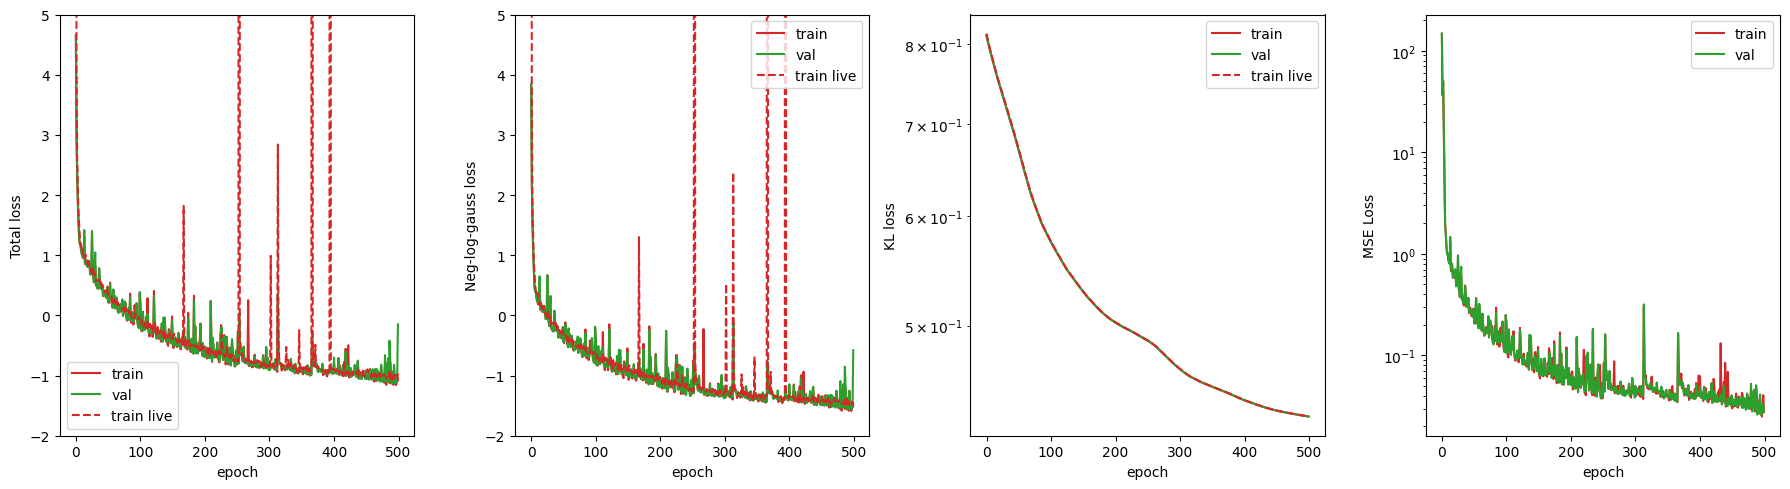

In [40]:
fig, axs = plt.subplots(1, 4, figsize=(18,5))

c1 = 'tab:red'
c2 = 'tab:green'

axs[0].plot(trn_losses, label="train", color=c1)
axs[0].plot(val_losses, label="val", color=c2)
axs[0].plot(trn_losses_live, label="train live", color=c1, ls='dashed')
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("Total loss")
axs[0].set_ylim(-2, 5)
axs[0].legend()

axs[1].plot(trn_nl_losses, label="train", color=c1)
axs[1].plot(val_nl_losses, label="val", color=c2)
axs[1].plot(trn_nl_losses_live, label="train live", color=c1, ls='dashed')
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("Neg-log-gauss loss")
axs[1].set_ylim(-2, 5)
axs[1].legend()

axs[2].plot(trn_kl_losses, label="train", color=c1)
axs[2].plot(val_kl_losses, label="val", color=c2)
axs[2].plot(trn_kl_losses_live, label="train live", color=c1, ls='dashed')
axs[2].set_yscale('log')
axs[2].set_xlabel("epoch")
axs[2].set_ylabel("KL loss")
axs[2].legend()


axs[3].plot(trn_mse_losses, label="train", color=c1)
axs[3].plot(val_mse_losses, label="val", color=c2)
axs[3].set_yscale('log')
axs[3].set_xlabel("epoch")
axs[3].set_ylabel("MSE Loss")
axs[3].legend()

fig.tight_layout()

We can see that both the train and validation losses are being reduced during training, the model is fitting well!

## Study the results

Now we want to get some visualisation of how well our amplitude regression has worked.

The simplest thing we can do is to pass our data through the neural network to get a predicted amplitude for each event, then histogram this and compare it to the histogram of the true amplitudes.

In [41]:
def get_prediction(model, dataloader, n_monte=30):

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():

        # sample from weight distributions
        amps_samples = []
        sigma2_samples = []
        for i in range(n_monte):
            print(f"Evaluating prediction: {i+1} / {n_monte}")
            # go through dataset
            amps = []
            sigma2 = []
            for X, y in dataloader:
                pred = model(X).detach().cpu().numpy()
                amps.extend(pred[:, 0]) # dimensions: [batch_size, 2]
                sigma2.extend(np.exp(pred[:, 1]))

            amps_samples.append(amps)
            sigma2_samples.append(sigma2)

    # dimensionaility (n_monte, batch_size)
    amps_samples = np.stack(amps_samples, axis=0)
    sigma2_samples = np.stack(sigma2_samples, axis=0)

    return amps_samples, sigma2_samples

In [42]:
# TURN OFF shuffeling to not mess up the weight sampling!
trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
tst_dataloader = DataLoader(tst_dataset, batch_size=64, shuffle=False)

# dimensionality is (n_monte, batch_size)
pred_trn_ampls_samples, sigma2_trn_samples = get_prediction(model, trn_dataloader)
pred_val_ampls_samples, sigma2_val_samples = get_prediction(model, val_dataloader)

# compute mean prediction, standard deviation of predictions and mean sigma-output, see lecture notes
pred_trn_ampls = np.mean(pred_trn_ampls_samples, axis=0) # mean prediction
pred_trn_ampls_std = np.std(pred_trn_ampls_samples, axis=0)
pred_trn_ampls_std_stoch = np.sqrt(np.mean(sigma2_trn_samples, axis=0))
pred_trn_ampls_std_tot = np.sqrt(pred_trn_ampls_std**2 + pred_trn_ampls_std_stoch**2)

# same for validation data
pred_val_ampls = np.mean(pred_val_ampls_samples, axis=0) # mean prediction
pred_val_ampls_std = np.std(pred_val_ampls_samples, axis=0)
pred_val_ampls_std_stoch = np.sqrt(np.mean(sigma2_val_samples, axis=0))
pred_val_ampls_std_tot = np.sqrt(pred_val_ampls_std**2 + pred_val_ampls_std_stoch**2)

print("Mean std pred: ", np.mean(pred_trn_ampls_std))
print("Mean std stoch: ", np.mean(pred_trn_ampls_std_stoch))


Evaluating prediction: 1 / 30
Evaluating prediction: 2 / 30
Evaluating prediction: 3 / 30
Evaluating prediction: 4 / 30
Evaluating prediction: 5 / 30
Evaluating prediction: 6 / 30
Evaluating prediction: 7 / 30
Evaluating prediction: 8 / 30
Evaluating prediction: 9 / 30
Evaluating prediction: 10 / 30
Evaluating prediction: 11 / 30
Evaluating prediction: 12 / 30
Evaluating prediction: 13 / 30
Evaluating prediction: 14 / 30
Evaluating prediction: 15 / 30
Evaluating prediction: 16 / 30
Evaluating prediction: 17 / 30
Evaluating prediction: 18 / 30
Evaluating prediction: 19 / 30
Evaluating prediction: 20 / 30
Evaluating prediction: 21 / 30
Evaluating prediction: 22 / 30
Evaluating prediction: 23 / 30
Evaluating prediction: 24 / 30
Evaluating prediction: 25 / 30
Evaluating prediction: 26 / 30
Evaluating prediction: 27 / 30
Evaluating prediction: 28 / 30
Evaluating prediction: 29 / 30
Evaluating prediction: 30 / 30
Evaluating prediction: 1 / 30
Evaluating prediction: 2 / 30
Evaluating predicti

First for the training data:

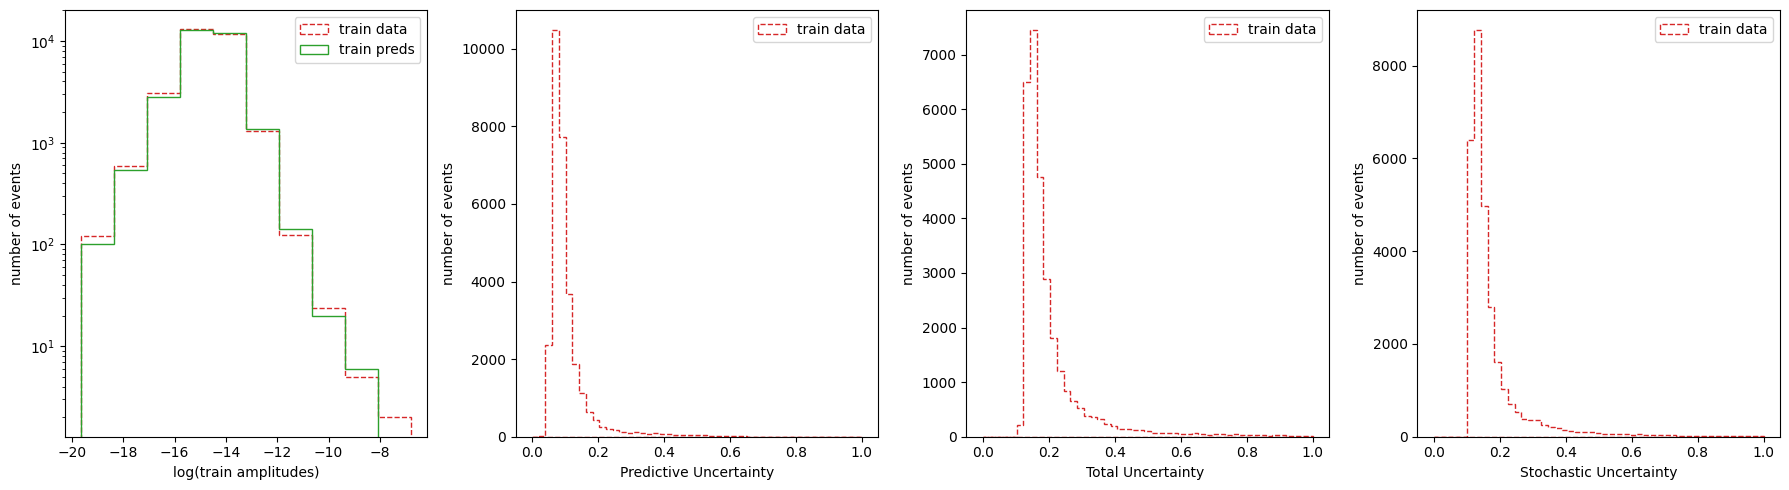

In [43]:
fig, axs = plt.subplots(1, 4, figsize=(18,5))

c1 = 'tab:red'
c2 = 'tab:green'

(n1, bins, patches1 ) = axs[0].hist(trn_ampl, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--")
(n2, _, patches2 ) = axs[0].hist(pred_trn_ampls, histtype='stepfilled', fill=None, edgecolor=c2, label="train preds", bins=bins)

bins= np.linspace(0, 1., 50)
(n3, _, patches3 ) = axs[1].hist(pred_trn_ampls_std, bins=bins, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--")
(n4, _, patches4 ) = axs[2].hist(pred_trn_ampls_std_tot, bins=bins, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--")
(n5, _, patches5 ) = axs[3].hist(pred_trn_ampls_std_stoch, bins=bins, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--")

axs[0].set_yscale('log')
axs[0].set_xlabel("log(train amplitudes)")
axs[0].set_ylabel("number of events")
axs[0].legend(loc='best')

axs[1].set_xlabel("Predictive Uncertainty")
axs[1].set_ylabel("number of events")
axs[1].legend(loc='best')

axs[2].set_xlabel("Total Uncertainty ")
axs[2].set_ylabel("number of events")
axs[2].legend(loc='best')

axs[3].set_xlabel("Stochastic Uncertainty")
axs[3].set_ylabel("number of events")
axs[3].legend(loc='best')

fig.tight_layout()

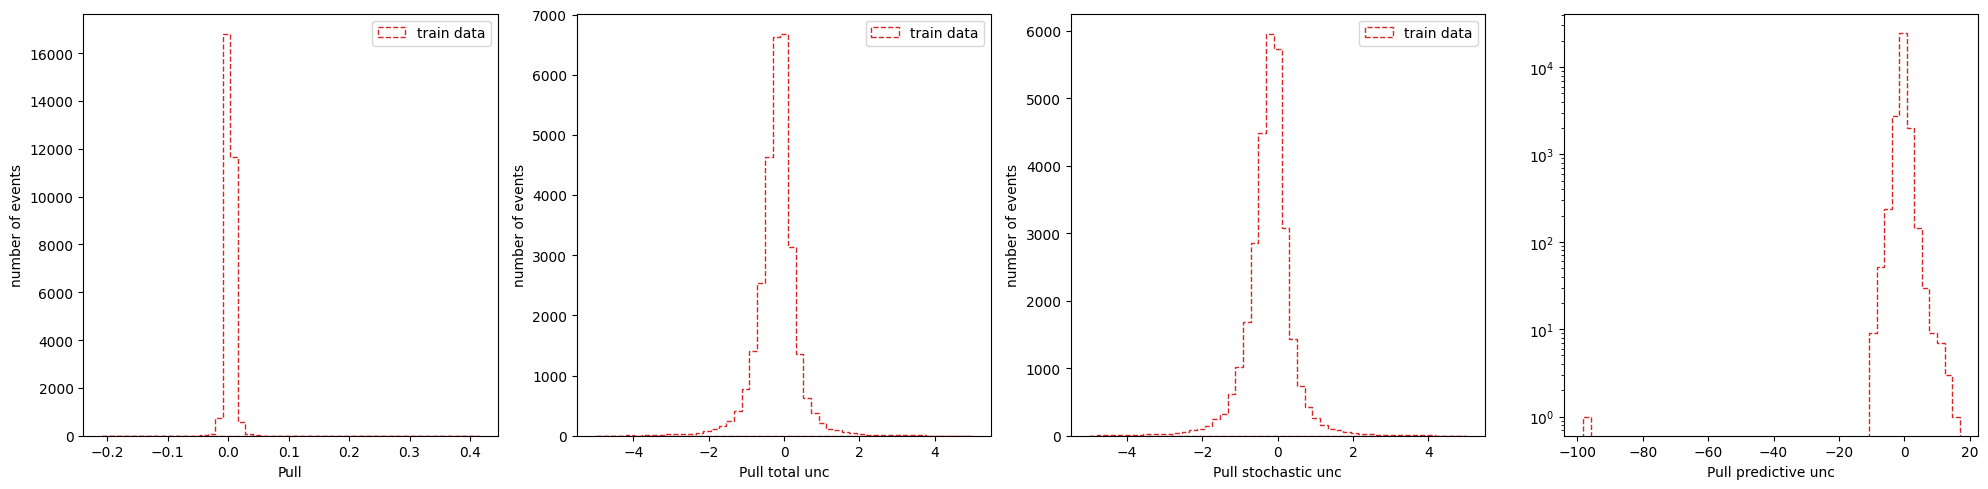

In [44]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))

c1 = 'tab:red'
c2 = 'tab:green'

n_bins = 50
bins = np.linspace(-5, 5, n_bins)

pull = (trn_ampl - pred_trn_ampls) / trn_ampl
pull_normalized_tot = (trn_ampl - pred_trn_ampls) / pred_val_ampls_std_tot
pull_normalized_stoch = (trn_ampl - pred_trn_ampls) / pred_val_ampls_std_stoch
pull_normalized = (trn_ampl - pred_trn_ampls) / pred_val_ampls_std


(n1, bins1, patches1 ) = axs[0].hist( pull, histtype='stepfilled', bins=n_bins, fill=None, edgecolor=c1, label="train data", ls="--" )
(n2, bins2, patches2 ) = axs[1].hist( pull_normalized_tot, histtype='stepfilled', bins=np.linspace(-5, 5, n_bins), fill=None, edgecolor=c1, label="train data", ls="--" )
(n3, bins3, patches3 ) = axs[2].hist( pull_normalized_stoch, histtype='stepfilled', bins=np.linspace(-5, 5, n_bins), fill=None, edgecolor=c1, label="train data", ls="--" )
(n4, bins4, patches4 ) = axs[3].hist( pull_normalized, histtype='stepfilled', bins=n_bins, fill=None, edgecolor=c1, label="train data", ls="--" )

axs[0].set_xlabel("Pull")
axs[0].set_ylabel("number of events")
axs[0].legend(loc='best')

axs[1].set_xlabel("Pull total unc")
axs[1].set_ylabel("number of events")
axs[1].legend(loc='best')

axs[2].set_xlabel("Pull stochastic unc")
axs[2].set_ylabel("number of events")
axs[2].legend(loc='best')

axs[3].set_yscale('log')
axs[3].set_xlabel("Pull predictive unc")

fig.tight_layout()

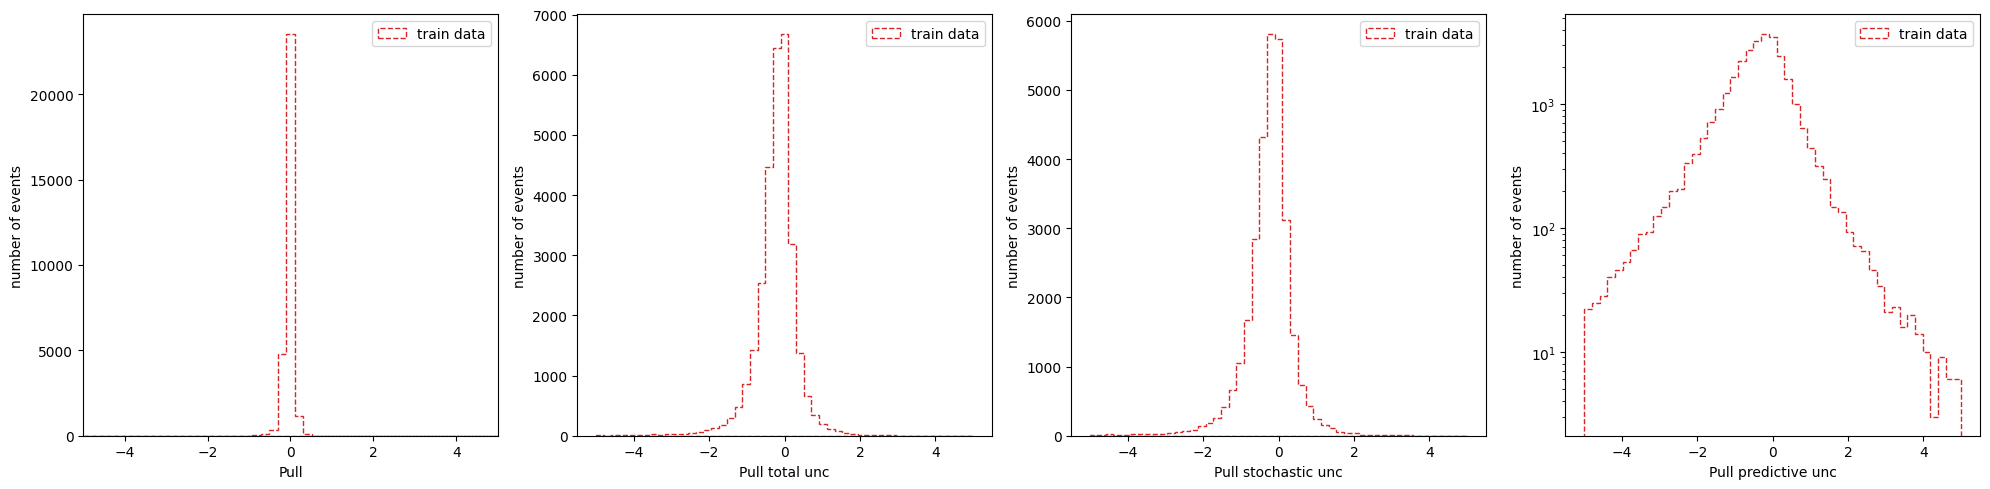

In [45]:
# same plots for exp(log (train amplitudes) ) = train amplitudes

fig, axs = plt.subplots(1, 4, figsize=(20,5))

c1 = 'tab:red'
c2 = 'tab:green'

n_bins = 50
bins =np.linspace(-5, 5, n_bins)

# revert preprocessing
trn_ampl_exp = np.exp(trn_ampl)
pred_trn_ampls_exp = np.exp(pred_trn_ampls)
pred_val_ampls_std_tot_exp = np.exp(trn_ampl) * pred_val_ampls_std_tot # error propagation
pred_val_ampls_std_stoch_exp = np.exp(trn_ampl) * pred_val_ampls_std_stoch # error propagation
pred_val_ampls_std_exp = np.exp(trn_ampl) * pred_val_ampls_std # error propagation

pull = (trn_ampl_exp - pred_trn_ampls_exp) / trn_ampl_exp
pull_normalized_tot = (trn_ampl_exp - pred_trn_ampls_exp) / pred_val_ampls_std_tot_exp
pull_normalized_stoch = (trn_ampl_exp - pred_trn_ampls_exp) / pred_val_ampls_std_stoch_exp
pull_normalized = (trn_ampl_exp - pred_trn_ampls_exp) / pred_val_ampls_std_exp
(n1, bins1, patches1 ) = axs[0].hist(pull, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--")
(n2, bins2, patches2 ) = axs[1].hist(pull_normalized_tot, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--")
(n3, bins3, patches3 ) = axs[2].hist(pull_normalized_stoch, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--")
(n4, bins4, patches4 ) = axs[3].hist(pull_normalized, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--")


axs[0].set_xlabel("Pull")
axs[0].set_ylabel("number of events")
axs[0].set_xlim([-5, 5])
axs[0].legend(loc='best')

axs[1].set_xlabel("Pull total unc")
axs[1].set_ylabel("number of events")
axs[1].legend(loc='best')

axs[2].set_xlabel("Pull stochastic unc")
axs[2].set_ylabel("number of events")
axs[2].legend(loc='best')

axs[3].set_yscale('log')
axs[3].set_xlabel("Pull predictive unc")
axs[3].set_ylabel("number of events")
axs[3].legend(loc='best')

fig.tight_layout()

The error is lowest in the regions where there is more training data, this is expected.  The more data the network has to learn from, the better it can learn to predict the correct amplitude.

And then for the validation data:

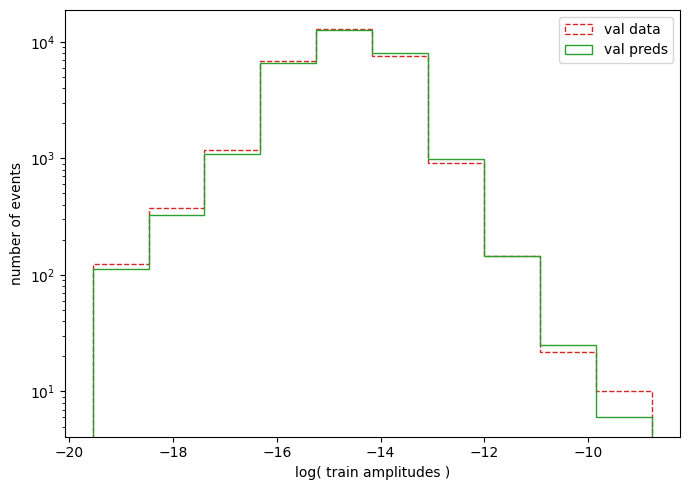

In [46]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))

c1 = 'tab:red'
c2 = 'tab:green'

(n1, bins, patches1) = axs.hist(val_ampl, histtype='stepfilled', fill=None, edgecolor=c1, label="val data", ls="--")
(n2, _, patches2) = axs.hist(pred_val_ampls, histtype='stepfilled', fill=None, edgecolor=c2, label="val preds", bins=bins)

axs.set_yscale('log')

axs.set_xlabel("log( train amplitudes )")
axs.set_ylabel("number of events")

axs.legend(loc='best')

fig.tight_layout()

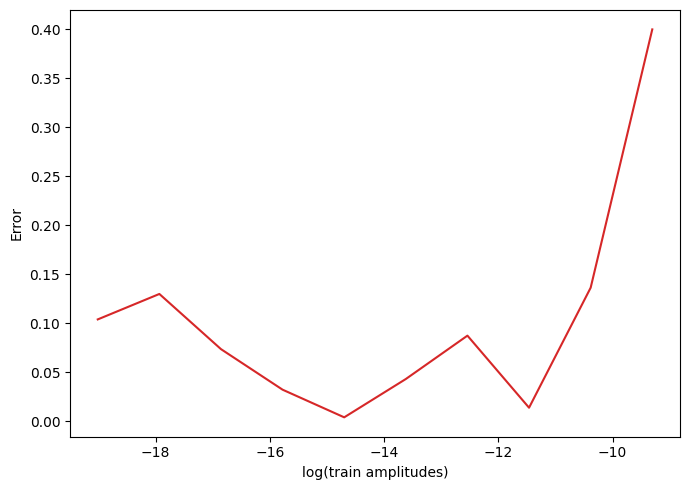

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot((bins[1:]+bins[:-1])/2., np.abs((n1-n2)/n1), color=c1)

axs.set_xlabel("log(train amplitudes)")
axs.set_ylabel("Error")

fig.tight_layout()